推荐系统实战-3
=============
隐语义模型实战
------------

使用 [Text8](http://mattmahoney.net/dc/textdata) 数据集训练word2vec

1.安装依赖库

In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
print('check：libs well prepared')

/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sangyongjia/anaconda3/en

check：libs well prepared


2.下载数据并解压

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  #判断文件是否存在
  if not os.path.exists(filename):
    #下载
    print('download...')
    filename, _ = urlretrieve(url + filename, filename)
  #校验大小
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print('exception %s' % statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


3.编码并替换低频次

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #每个词出现的次数
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #单词到数字的映射
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #数字到单词的映射
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#映射之后的训练数据
data, count, dictionary, reverse_dictionary = build_dataset(words)
#
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


4.生成skip-gram训练数据

In [6]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # x y
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # context word context
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    # 循环使用
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # 
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']


5.定义网络结构

In [7]:
batch_size = 128
embedding_size = 128 # 
skip_window = 1 # 
num_skips = 2 # 
valid_size = 16 # 
valid_window = 100 #
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入数据
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 定义变量
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  #本次训练数据对应的embedding
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # batch loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  #优化loss，更新参数
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  #归一化
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  #用已有embedding计算valid的相似次
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

6.运行训练流程

In [10]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps+1):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    // 
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    #2000次打印loss
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # 打印valid效果
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 #相似度最高的5个词
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

TypeError: generate_cbow_batch() takes 2 positional arguments but 3 were given

7.可视化

In [49]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

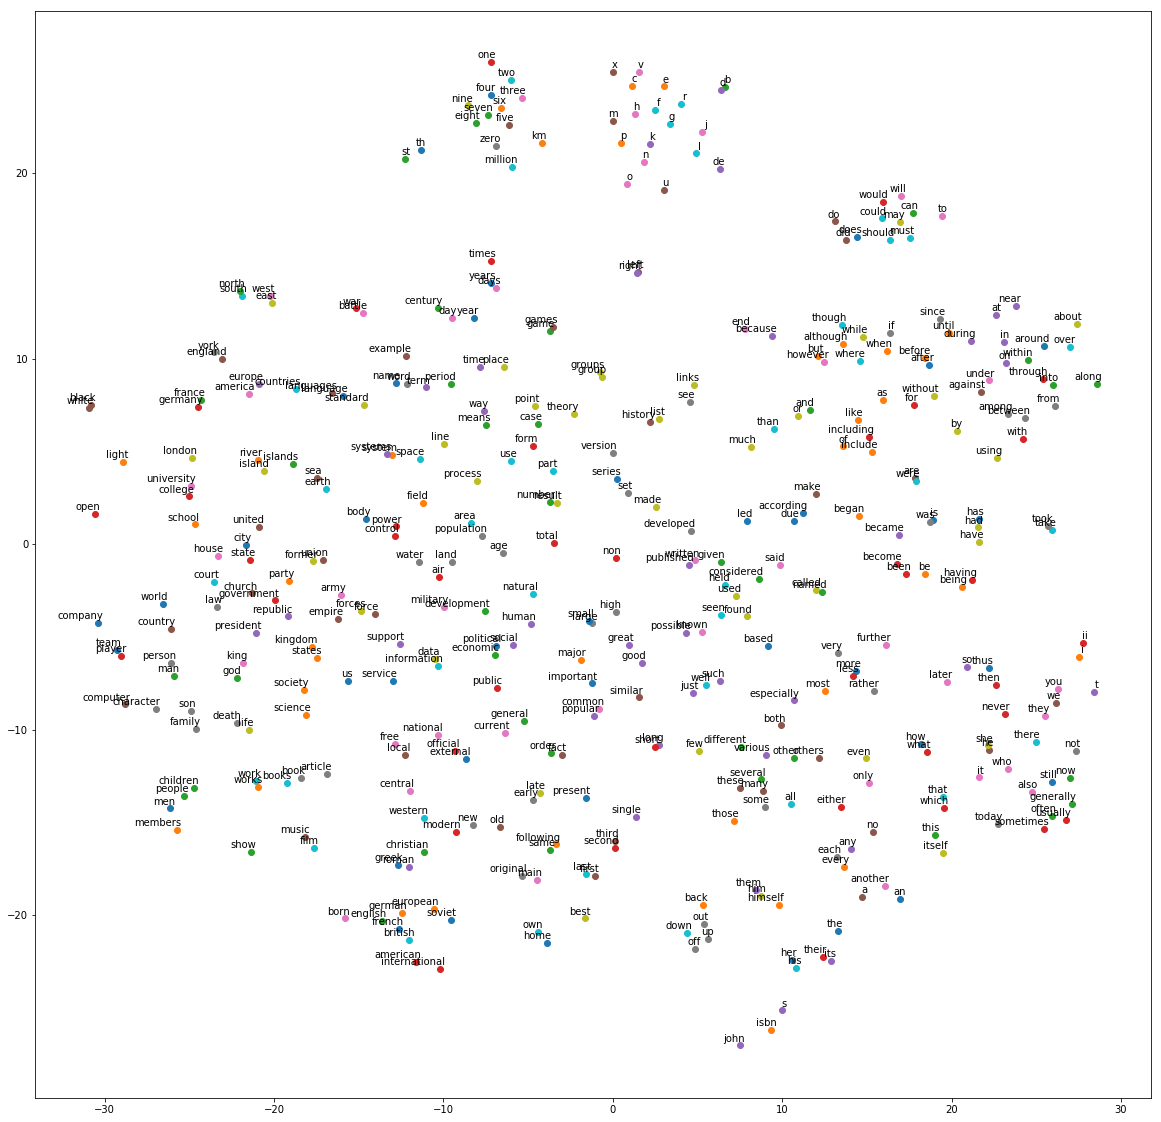

In [50]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

作业：使用CBOW模型训练word2vec，获得embedding并比较和skip-gram的差异
------------
生成样本的方式不同

In [7]:
data_index = 0

def cbow_batch(batch_size, bag_window):
  global data_index
  batch = np.ndarray(shape=(batch_size,bag_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    batch[i] = list(buffer)[:bag_window] + list(buffer)[bag_window+1:]
    labels[i] = buffer[bag_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

batch, labels = cbow_batch(8,1)
print('batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
print('labels:', [reverse_dictionary[l] for l in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


网络定义基本相同，只改变了输入数据的维度和输入前的处理

In [14]:
batch_size = 128
embedding_size = 128 
bag_window = 1 # 跟skip_window作用相同
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入变量的维度不同
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
 
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # inputs先做sum pooling再输入
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

调用batch样本的生成的方法不同，其他相同

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = cbow_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
       
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.931688
Nearest to was: formless, male, ki, destabilizing, unconsciousness,
Nearest to it: astros, genitive, specializes, eugenius, chopsticks,
Nearest to be: soliloquy, consecration, dystrophy, extravagant, admin,
Nearest to some: shaw, eee, raged, nicene, slower,
Nearest to two: trademarked, slowing, clipping, encapsulated, falk,
Nearest to are: salian, greeneville, nilsson, bentheim, icao,
Nearest to these: minorca, lvaro, civilisations, thin, silverstein,
Nearest to he: saboteurs, simo, starting, thunderbird, respectively,
Nearest to other: breached, literary, shrinks, diff, touma,
Nearest to s: enunciated, frelimo, hilliard, apprehend, weapon,
Nearest to time: pirandello, redirect, basque, attalus, zhukov,
Nearest to eight: anaheim, swaziland, constituting, dorsal, touchstone,
Nearest to five: dualistic, ambitious, herbie, whipping, confined,
Nearest to american: presented, cretians, bigger, outnumber, headers,
Nearest to between: dipole, nemes

可视化代码相同

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)